# Miscellaneous code

This notebook contains miscellaneous snippets that are useful for understanding the SIR dynamical system and for producing one or more of the numbers quoted in the paper

In [55]:
%load_ext autoreload
%autoreload 2

from code import utils as cutil
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Minimum $S$ in sample

This snippet calculates the minimum $S$ observed in sample

In [414]:
name = []
val = []
for iso in ["CHN", "KOR", "FRA", "ITA", "IRN", "USA"]:
    for adm in [1, 2]:
        if adm == 1:
            grps = "adm1_name"
        elif adm == 2:
            grps = ["adm1_name", "adm2_name"]
        try:
            df = cutil.load_processed_data(iso, adm)
        except:
            continue
        x = df.groupby(level=grps)[["cum_confirmed_cases", "population"]].max()
        val.append((1 - x.cum_confirmed_cases / x.population).min())
        name.append(f"{iso}_{adm}_{(1 - x.cum_confirmed_cases / x.population).idxmin()}")
pd.Series(val, index=name)

CHN_2_('Hubei', 'Wuhan')       0.994015
KOR_1_Daegu                    0.997475
FRA_1_GrandEst                 0.999412
ITA_1_Lombardia                0.998239
ITA_2_('Lombardia', 'Lodi')    0.993723
IRN_1_Semnan                   0.999203
USA_1_Washington               0.999849
dtype: float64

## SIR simulation

A toy SIR model with fixed predicted $\hat{g}$, under assumptions of different $\gamma$

(1, 1000000.0)

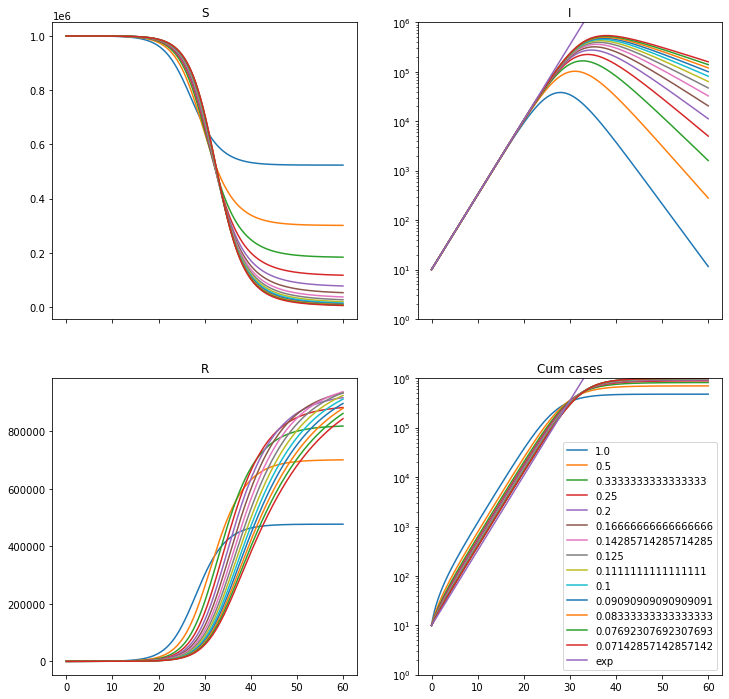

In [177]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True)

n_days = 60
tsteps_per_day = 6
pop = 1e6
gamma = 1 / 3
model_pred = 0.35


S = np.ones(n_days * tsteps_per_day) * np.nan
I = np.ones(n_days * tsteps_per_day) * np.nan
R = np.ones(n_days * tsteps_per_day) * np.nan
g = np.ones(n_days * tsteps_per_day) * np.nan

t = np.linspace(0, 1, len(I)) * n_days

for j in [1 / a for a in range(1, 15)]:
    gamma = j

    R[0] = 0
    I[0] = 10 / pop
    S[0] = 1 - I[0]

    recovery_rate = gamma / tsteps_per_day

    for i in range(1, n_days * tsteps_per_day):
        new_infections_disc_rate = (model_pred + gamma) / tsteps_per_day * S[i - 1]

        # this is the exponential rate b/c we can (it's an exponential ode)
        I[i] = np.exp(new_infections_disc_rate - recovery_rate) * I[i - 1]

        # these are discretized
        S[i] = S[i - 1] - new_infections_disc_rate * I[i - 1]
        R[i] = R[i - 1] + recovery_rate * I[i - 1]

    cum_cases = I + R
    S, I, R, cum_cases = S * pop, I * pop, R * pop, cum_cases * pop
    axs[0, 0].plot(t, S, label=str(j))
    axs[0, 1].plot(t, I, label=str(j))
    axs[1, 0].plot(t, R, label=str(j))
    axs[1, 1].plot(t, cum_cases, label=str(j))

    g = (model_pred + gamma) / tsteps_per_day * S / pop - recovery_rate

# exponential version
I[0] = 10 / pop
for i in range(1, n_days * tsteps_per_day):
    I[i] = np.exp(model_pred / tsteps_per_day) * I[i - 1]
axs[0, 1].plot(t, I * pop, label="exp")
axs[1, 1].plot(t, I * pop, label="exp")

axs[0, 0].set_title("S")
axs[0, 1].set_title("I")
axs[1, 0].set_title("R")
axs[1, 1].set_title("Cum cases")
plt.legend()
axs[0, 1].set_yscale("log")
axs[1, 1].set_yscale("log")
axs[0, 1].set_ylim(1, 1e6)
axs[1, 1].set_ylim(1, 1e6)